
---

 Introduction**

Welcome to the comprehensive solution notebook, which brings together every step of the pipeline—from data ingestion and preprocessing to model training and evaluation—into a single, integrated document. 

**Problem Overview**

CubeSats have emerged as cost-effective platforms for astronomical sensing despite their inherent limitations in size, weight, computational power, and data transmission speed. The VERTECS mission, a collaboration led by the Kyushu Institute of Technology (Kyutech) and its partners, is designed to study the optical extragalactic background light (EBL) to better understand the formation history of stars. Equipped with a small-aperture telescope and high-precision attitude control, VERTECS captures crucial astronomical data for ground analysis.

**Figure 1: VERTECS Satellite Design**  
<figure style="text-align:center;">
    <img src="https://raw.githubusercontent.com/Hack4Dev/CubeSat_ImageClassify/main/pictures/SAT.png" class="center-image" style="width:900px; height:400px;">
    <figcaption>Figure 1: VERTECS Satellite Design (Source: Hack4Dev)</figcaption>
</figure>

Due to their compact nature, CubeSats face significant challenges such as limited onboard storage, processing capabilities, and slow communication channels, which can delay the transmission of vital data back to Earth.

To overcome these obstacles, our approach leverages onboard machine learning. By processing data directly on the CubeSat, the system can intelligently prioritize and select the most valuable images for transmission, thereby optimizing the use of limited bandwidth.

**Challenge**

The challenge is to develop a lightweight, efficient machine learning model that accurately classifies CubeSat data, ensuring that high-priority images are transmitted despite resource constraints. Our solution achieves this by balancing computational efficiency with high classification accuracy, making it well-suited for resource-constrained environments.

This notebook encapsulates the entire solution pipeline, ensuring full reproducibility and clarity in our approach. 

---

In [1]:
import zipfile
import os
import numpy as np

# Path to the zip file in the Kaggle input directory
zip_file_path = '/kaggle/input/10hack/files-archive'

# Define the extraction directory
extracted_path = '/kaggle/working/10hack/'

# Unzip the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

# List the extracted files to verify
extracted_files = os.listdir(extracted_path)
print("Extracted files:", extracted_files)

Extracted files: ['val_images.npy', 'val_labels.npy', 'test_images1.npy', 'train_labels.npy', 'test_labels.npy', 'train_images.npy']


In [2]:
! pip install -q tensorflow-model-optimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 7.4 MB/s eta 0:00:00


In [3]:
# Standard Library Imports
import os
import sys
import gc
import time
import threading
import tracemalloc

# Third-Party Libraries
import numpy as np
import psutil
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
from absl import app as absl_app
from absl import flags
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

# TensorFlow and Keras Imports
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow_model_optimization.python.core.keras.compat import keras

# TensorFlow Model Optimization (TF-MOT) Imports
from tensorflow_model_optimization.python.core.sparsity.keras import prune
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_schedule
from tensorflow_model_optimization.sparsity import keras as pruning_callbacks
from tensorflow_model_optimization.python.core.sparsity.keras.pruning_schedule import PolynomialDecay
from tensorflow_model_optimization.quantization.keras import quantize_scope
from tensorflow_model_optimization.sparsity.keras import prune_scope
from tensorflow_model_optimization.python.core.quantization.keras import quantize
from tensorflow_model_optimization.python.core.quantization.keras.collab_opts.prune_preserve import (
    default_8bit_prune_preserve_quantize_scheme,
)

In [4]:
# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("Using GPU for training.")
    # Set memory growth to avoid overloading GPU memory
    for gpu in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("GPU not found. Using CPU instead.")

Using GPU for training.


In [ ]:
# This will show the devices being used
# tf.debugging.set_log_device_placement(True)

In [5]:
# Enable mixed precision training
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [6]:
# Avoid issues with automatic flag parsing
sys.argv = sys.argv[:1]  # Keep only the script name, remove any other arguments

FLAGS = flags.FLAGS

batch_size = 128
num_classes = 10
epochs = 12

flags.DEFINE_string('output_dir', '/kaggle/working/cubesat_train/',
                    'Output directory to hold tensorboard events')

# Run your main function
# absl_app.run(main)

In [6]:
def build_layerwise_model(input_shape, num_classes=5, **pruning_params):
    """
    Builds a sequential Keras model with layer-wise pruning for image classification.

    This function constructs a model consisting of multiple convolutional layers 
    (using SeparableConv2D) with pruning applied via low-magnitude pruning, 
    followed by batch normalization, ReLU activation, and max pooling layers. 
    The model then performs global average pooling, applies dropout for regularization, 
    and finally uses a pruned dense layer with softmax activation for classification.

    Parameters
    ----------
    input_shape : tuple
        Shape of the input data (e.g., (height, width, channels)).
    num_classes : int, optional
        Number of output classes. Default is 5.
    **pruning_params : dict
        Additional keyword arguments for configuring the pruning parameters. 
        These parameters are passed to the `prune.prune_low_magnitude` function for each layer.

    Returns
    -------
    keras.Sequential
        A Keras Sequential model with the defined architecture and pruning applied.
    """
    
    l = keras.layers
    
    return keras.Sequential([
        prune.prune_low_magnitude(
            l.SeparableConv2D(32, (3, 3), padding='same',
                              depthwise_regularizer=keras.regularizers.L2(0.001),
                              pointwise_regularizer=keras.regularizers.L2(0.001)
                             ),
              input_shape=input_shape, **pruning_params),
        l.BatchNormalization(),
        l.Activation('relu'),
        l.MaxPooling2D((2, 2), padding='same'),

        prune.prune_low_magnitude(l.SeparableConv2D(64, (3, 3), padding='same',
                                                    depthwise_regularizer=keras.regularizers.L2(0.001),
                                                    pointwise_regularizer=keras.regularizers.L2(0.001)
                                                   ),
              **pruning_params),
        l.BatchNormalization(),
        l.Activation('relu'),
        l.MaxPooling2D((2, 2), padding='same'),

        prune.prune_low_magnitude(l.SeparableConv2D(128, (3, 3), padding='same',
                                                    depthwise_regularizer=keras.regularizers.L2(0.001),
                                                    pointwise_regularizer=keras.regularizers.L2(0.001)
                                                   ),
              **pruning_params),
        l.BatchNormalization(),
        l.Activation('relu'),
        l.MaxPooling2D((2, 2), padding='same'),

        l.GlobalAveragePooling2D(),
        l.Dropout(0.5),        
        prune.prune_low_magnitude(l.Dense(num_classes), **pruning_params),
        l.Activation('softmax')
    ])

In [7]:
def train_and_save(models, train_dataset, val_dataset, test_dataset, batch_size=32, epochs=40):
    """
    Trains a list of pruned Keras models and saves each trained model in multiple formats,
    including TensorFlow SavedModel, HDF5, and Pickle. In addition, the function converts
    the best performing model to TensorFlow Lite format and evaluates its performance.

    The training procedure uses a cosine decay restart learning rate schedule with the Adam
    optimizer and monitors training with several callbacks:
      - UpdatePruningStep and PruningSummaries for pruning updates and logging.
      - EarlyStopping to halt training if the validation loss does not improve.
      - ModelCheckpoint to save the best model based on validation loss.

    After training, the best model is loaded (using the pruning scope), evaluated on the test dataset,
    and then saved in various formats. The function also demonstrates how to reload and evaluate the model
    from each saved format. Finally, it converts the model to TensorFlow Lite format, evaluates it,
    and computes common evaluation metrics such as accuracy, precision, recall, F1 score, and the confusion matrix.

    Parameters
    ----------
    models : list
        A list of Keras models to be trained. Each model is assumed to have pruning applied.
    train_dataset : tf.data.Dataset
        The TensorFlow dataset used for training.
    val_dataset : tf.data.Dataset
        The TensorFlow dataset used for validation.
    test_dataset : tf.data.Dataset
        The TensorFlow dataset used for testing the final model.
    batch_size : int, optional
        The batch size used during training (default is 32).
    epochs : int, optional
        The number of training epochs (default is 40).

    Returns
    -------
    None
        The function saves the trained models in various formats and prints evaluation metrics.
    """
    
    for model in models:

        # Define dataset and batch size
        train_dataset_size = 9711  # Total number of training images
        
        # Calculate the steps per epoch
        steps_per_epoch = train_dataset_size // batch_size
        
        # Define the first decay steps (based on epochs of training)
        first_decay_steps = steps_per_epoch * epochs

        lr_schedule = keras.optimizers.schedules.CosineDecayRestarts(
            initial_learning_rate=1e-3,  # Start with a higher LR if needed
            first_decay_steps=first_decay_steps,  # Adjust based on dataset size
            t_mul=2.0,  # Multiplier for the cycle length
            m_mul=0.9,  # Reduce max LR by 10% each cycle
            alpha=1e-5  # Minimum LR
        )
        
        optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

        model.compile(
            loss=keras.losses.categorical_crossentropy,
            optimizer=optimizer,
            metrics=['accuracy'],
        )

        # Print the model summary.
        model.summary()

        # Define callbacks
        callbacks = [
            pruning_callbacks.UpdatePruningStep(),
            pruning_callbacks.PruningSummaries(log_dir='/kaggle/working/pruning_logs/'),
            keras.callbacks.EarlyStopping(monitor='val_loss', 
                                          patience=10, mode='auto', 
                                          restore_best_weights=True),
            keras.callbacks.ModelCheckpoint('/kaggle/working/best_checkpoint_model.h5', 
                            monitor='val_loss', save_best_only=True, 
                            mode='auto', verbose=1)
            
        ]

        # Fit the model using the tf.data.Dataset
        model.fit(
            train_dataset,
            epochs=epochs,
            verbose=1,
            validation_data=val_dataset,
            callbacks=callbacks
        )

        with prune_scope():
            # Load and use the best model saved by ModelCheckpoint
            best_model = keras.models.load_model('/kaggle/working/best_checkpoint_model.h5')
    
        # Evaluate on test data
        score = best_model.evaluate(test_dataset, verbose=0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])

        # Save as TensorFlow SavedModel
        saved_model_dir = '/kaggle/working/saved_model/'
        print('Saving model to TensorFlow SavedModel format at:', saved_model_dir)
        keras.models.save_model(best_model, saved_model_dir, save_format='tf')

        # Save as HDF5 (.h5)
        h5_file = '/kaggle/working/best_model.h5'
        print('Saving model to HDF5 format at:', h5_file)
        model.save(h5_file, save_format='h5')

        # Save as Pickle (.pkl)
        # Since Keras models aren't directly picklable, we store the architecture and weights.
        model_json = best_model.to_json()
        model_weights = best_model.get_weights()
        pkl_file = '/kaggle/working/model.pkl'
        print('Saving model to Pickle format at:', pkl_file)
        with open(pkl_file, 'wb') as f:
            pickle.dump({'model_json': model_json, 'model_weights': model_weights}, f)

        # Optional: Verify the SavedModel loading
        print('Loading model from TensorFlow SavedModel format...')
        loaded_model = keras.models.load_model(saved_model_dir)
        score = loaded_model.evaluate(test_dataset, verbose=0)
        print('Test loss after loading SavedModel:', score[0])
        print('Test accuracy after loading SavedModel:', score[1])

        
        # Optional: Verify HDF5 model loading
        print('Loading model from HDF5 format...')
        
        with prune_scope():
            loaded_h5_model = keras.models.load_model(h5_file)
            
        score = loaded_h5_model.evaluate(test_dataset, verbose=0)
        print('Test loss after loading HDF5 model:', score[0])
        print('Test accuracy after loading HDF5 model:', score[1])
        
        
        # Optional: Verify Pickle model loading
        print('Loading model from Pickle format...')
        with open(pkl_file, 'rb') as f:
            data = pickle.load(f)
        with prune_scope():
            loaded_pickle_model = keras.models.model_from_json(data['model_json'])
            
        loaded_pickle_model.set_weights(data['model_weights'])
        # Compile the loaded pickle model before evaluating.
        loaded_pickle_model.compile(
            loss=keras.losses.categorical_crossentropy,
            optimizer='adam',
            metrics=['accuracy'],
        )
        score = loaded_pickle_model.evaluate(test_dataset, verbose=0)
        
        print('Test loss after loading Pickle model:', score[0])
        print('Test accuracy after loading Pickle model:', score[1])

        # Convert and save as TFLite (.tflite)
        print('Converting the best model to TFLite format...')
        converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        tflite_model = converter.convert()
        tflite_file = '/kaggle/working/model.tflite'
        with open(tflite_file, 'wb') as f:
            f.write(tflite_model)
        print('TFLite model saved at:', tflite_file)

        # Load and evaluate the TFLite (.tflite) model 
        print('Loading and evaluating the TFLite model...')
        interpreter = tf.lite.Interpreter(model_path=tflite_file)
        interpreter.allocate_tensors()
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()
        # Variables to store predictions and ground truth.
        predictions = []
        ground_truth = []
    
        for batch_images, batch_labels in test_dataset:
            batch_images_np = batch_images.numpy()
            batch_labels_np = batch_labels.numpy()
            for i in range(len(batch_images_np)):
                # Process ground truth label (handle one-hot encoding if needed)
                label = batch_labels_np[i]
                if label.ndim > 0:
                    label = np.argmax(label)
                ground_truth.append(label)
                
                # Prepare input and run inference on the TFLite model.
                input_data = np.expand_dims(batch_images_np[i], axis=0)
                interpreter.set_tensor(input_details[0]['index'], input_data)
                interpreter.invoke()
                output_data = interpreter.get_tensor(output_details[0]['index'])
                pred = np.argmax(output_data)
                predictions.append(pred)
                
        # Compute evaluation metrics.
        tflite_accuracy = accuracy_score(ground_truth, predictions)
        tflite_precision = precision_score(ground_truth, predictions, average='weighted')
        tflite_recall = recall_score(ground_truth, predictions, average='weighted')
        tflite_f1 = f1_score(ground_truth, predictions, average='weighted')
        tflite_cm = confusion_matrix(ground_truth, predictions)
        
        print('TFLite Model Evaluation:')
        print('Accuracy:', tflite_accuracy)
        print('Precision:', tflite_precision)
        print('Recall:', tflite_recall)
        print('F1 Score:', tflite_f1)
        print('Confusion Matrix:\n', tflite_cm)    

In [25]:
def create_preprocessed_dataset(dataset_path, images_filename, labels_filename, 
                                batch_size=32, num_classes=5, shuffle=False,
                                normalization_params=None):
    """
    Loads images/labels from disk using memory mapping and creates a batched/prefetched tf.data.Dataset.
    Processes data entirely on-demand without loading full arrays into RAM.
    
    Optionally, normalization parameters (global_mean, global_var) can be provided.
    This allows you to compute them once on the training dataset and reuse for validation/test.
    
    Parameters:
        dataset_path (str): Path to the dataset directory.
        images_filename (str): Filename for the images (.npy file).
        labels_filename (str): Filename for the labels (.npy file).
        batch_size (int): Size of the batches.
        num_classes (int): Number of label classes for one-hot encoding.
        shuffle (bool): If True, shuffles the dataset by shuffling indices in the generator.
        normalization_params (tuple or None): A tuple (global_mean, global_var) to be used for normalization.
            If None, computes statistics from the dataset (suitable for training data).
        
    Returns:
        ds (tf.data.Dataset): A dataset yielding preprocessed, batched, and prefetched data.
        normalization_params (tuple): The computed (global_mean, global_var). When providing these for 
                                      validation/test sets, you can ignore the returned values.
    """
    
    # Load memory-mapped arrays (virtual disk pointers)
    images_mmap = np.load(f"{dataset_path}/{images_filename}", mmap_mode='r')
    labels_mmap = np.load(f"{dataset_path}/{labels_filename}", mmap_mode='r')
    
    # Print the shape of the entire dataset (total number of samples)
    print(f"Total samples in {images_filename}: {images_mmap.shape[0]}")
    
    # Compute global normalization parameters only if not provided.
    if normalization_params is None:
        def compute_global_stats(images):
            total_sum = np.zeros(3)
            total_sum_sq = np.zeros(3)
            count = 0
            for i in range(len(images)):
                img = images[i].astype(np.float64)  # use higher precision for accumulation
                total_sum += np.sum(img, axis=(0, 1))  # Sum across height & width, keep channels
                total_sum_sq += np.sum(np.square(img), axis=(0, 1))
                count += img.shape[0] * img.shape[1]  # Total pixels per channel
            mean = total_sum / count
            var = (total_sum_sq / count) - np.square(mean)
            return mean, var
        
        global_mean, global_var = compute_global_stats(images_mmap)
        normalization_params = (global_mean, global_var)
    else:
        global_mean, global_var = normalization_params

    # Convert normalization parameters to tf.constant for use in the pipeline.
    global_mean = tf.constant(global_mean, dtype=tf.float32)
    global_var = tf.constant(global_var, dtype=tf.float32)
    
    # Generator function to read data on demand, with optional shuffling.
    def disk_reader():
        images = images_mmap  # keep reference in scope
        labels = labels_mmap
        indices = np.arange(len(images))
        if shuffle:
            np.random.shuffle(indices)
        for i in indices:
            yield images[i], labels[i]
    
    # Create dataset with explicit output signature
    output_signature = (
        tf.TensorSpec(shape=images_mmap.shape[1:], dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
    ds = tf.data.Dataset.from_generator(disk_reader, output_signature=output_signature)
    
    # Preprocessing function using training dataset normalization parameters
    def preprocess_fn(image, label):
        image = tf.cast(image, tf.float32)
        standardized_image = (image - global_mean) / tf.sqrt(global_var + 1e-8)
        one_hot_label = tf.one_hot(label, num_classes)
        return standardized_image, one_hot_label
    
    ds = ds.map(preprocess_fn, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    
    print(f"Disk-based pipeline created from {dataset_path}")
    
    return ds, normalization_params

---
## Data Analysis and Preprocessing

The data folder contains three types of datasets, each saved as numpy files along with their respective label files. The datasets are organized as follows:

- **train_images.npy**: Contains images for training machine and deep learning models, with the associated labels in **train_labels.npy**.
- **val_images.npy**: Contains images for validating the trained models, with corresponding labels in **val_labels.npy**.
- **test_images.npy**: Contains images for testing the trained models, with labels stored in **test_labels.npy**.

These datasets can now be read and explored.

In [26]:
# Define data set path, classes in the labels, and batch size
dataset_path = '/kaggle/working/10hack'
num_classes = 5
batch_size = 32

# Create Train dataset
train_dataset, norm_params = create_preprocessed_dataset(
    dataset_path, 'train_images.npy', 'train_labels.npy', 
    batch_size=batch_size, num_classes=num_classes, 
    shuffle=True, normalization_params=None  # Will compute from training data
)

Total samples in train_images.npy: 9711
Disk-based pipeline created from /kaggle/working/10hack


In [27]:
# Validation Datasets Unpack to get only the dataset; ignore the normalization parameters
val_dataset, _ = create_preprocessed_dataset(
    dataset_path, 'val_images.npy', 'val_labels.npy', 
    batch_size=batch_size, num_classes=num_classes, 
    shuffle=False, 
    normalization_params=norm_params
)

Total samples in val_images.npy: 3237
Disk-based pipeline created from /kaggle/working/10hack


In [28]:
# Test Datasets Unpack to get only the dataset; ignore the normalization parameters
test_dataset, _ = create_preprocessed_dataset(
    dataset_path, 'test_images1.npy', 'test_labels.npy', 
    batch_size=batch_size, num_classes=num_classes, 
    shuffle=False,
    normalization_params=norm_params
)

Total samples in test_images1.npy: 3237
Disk-based pipeline created from /kaggle/working/10hack


In [29]:
# Check the shape of the entire dataset by taking a sample batch
for images, labels in train_dataset.take(1):
    print(f"Train images shape: {images.shape}")
    print(f"Train labels shape: {labels.shape}")

for images, labels in val_dataset.take(1):
    print(f"Validation images shape: {images.shape}")
    print(f"Validation labels shape: {labels.shape}")

for images, labels in test_dataset.take(1):
    print(f"Test images shape: {images.shape}")
    print(f"Test labels shape: {labels.shape}")

Train images shape: (32, 512, 512, 3)
Train labels shape: (32, 5)
Validation images shape: (32, 512, 512, 3)
Validation labels shape: (32, 5)
Test images shape: (32, 512, 512, 3)
Test labels shape: (32, 5)


### Dataset Summary  

| Split       | Samples | Image Shape  | Channels |  
|------------|---------|--------------|----------|  
| Training   | 9,711   | (512, 512)   | RGB (3)  |  
| Validation | 3,237   | (512, 512)   | RGB (3)  |  
| Testing    | 3,237   | (512, 512)   | RGB (3)  |

---
### Visualising the data

#### 1. Visualize a Grid of Sample Images

---
The dataset we will be working with contains five classes, described as follows:

1. **Blurry:** Data captured while the satellite is in motion, resulting in blurred images.
2. **Corrupt:** Images with defects from improper camera priming or stray light.
3. **Missing Data:** Images with partial or complete data loss.
4. **Noisy:** Images over-saturated with noise from radiation or other sources.
5. **Priority:** Clear images suitable for scientific analysis on the ground.
Now, Let’s take a look at these datasets.
---

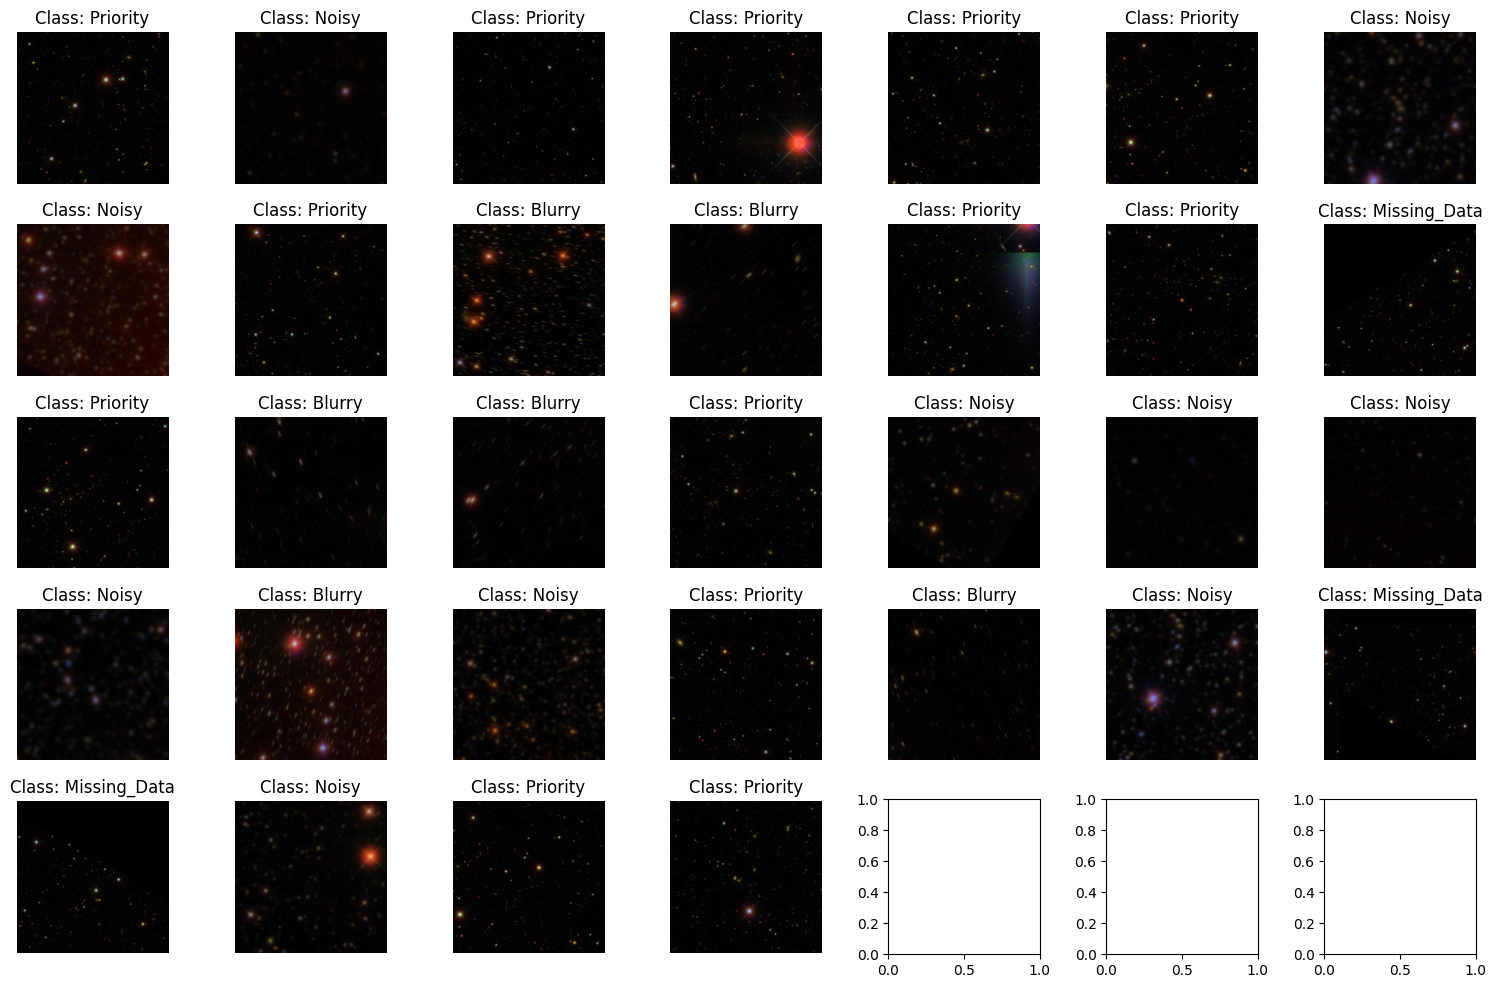

In [19]:
# Unnormalize function: converts standardized images back to their original scale.
def unnormalize(image, mean, var):
    return image * tf.sqrt(var + 1e-8) + mean

# Convert normalization parameters to tf.constant
global_mean = tf.constant(norm_params[0], dtype=tf.float32)
global_var  = tf.constant(norm_params[1], dtype=tf.float32)

# Define the class names
class_names = ["Blurry", "Corrupt", "Missing_Data", "Noisy", "Priority"]

def visualize_image_grid(dataset, mean, var, num_images=32):
    """
    Visualizes a grid of images from a dataset, showing different images each time.

    Parameters:
    - dataset: A tf.data.Dataset yielding (images, labels).
    - mean: Global mean used for unnormalizing the images.
    - var: Global variance used for unnormalizing the images.
    - num_images: Number of images to display.
    """
    # Take one batch from the dataset (this will be different on each run if dataset is shuffled)
    for standardized_images, one_hot_labels in dataset.take(1):
        # Unnormalize images for visualization
        images = unnormalize(standardized_images, mean, var)
        
        # Convert to NumPy arrays. Depending on your original range, you might need to rescale.
        images_np = images.numpy()
        images_np = np.clip(images_np, 0, 255).astype(np.uint8)
        
        # Get the integer labels from one-hot encoding
        labels = tf.argmax(one_hot_labels, axis=-1).numpy()

        # Shuffle the images and labels within the batch to ensure randomness
        indices = np.arange(images_np.shape[0])
        np.random.shuffle(indices)
        
        # Select up to `num_images` images from the shuffled batch
        selected_indices = indices[:num_images]

        # Determine grid size dynamically
        grid_rows = int(np.sqrt(num_images))  # Square root for near-square layout
        grid_cols = int(np.ceil(num_images / grid_rows))  # Ensure enough columns

        # Create a grid and plot images
        fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, 10))
        axes = axes.flatten()
        for i in range(num_images):
            if i < len(selected_indices):
                image_idx = selected_indices[i]
                axes[i].imshow(images_np[image_idx])
                class_label = labels[image_idx]
                class_name = class_names[class_label] if class_label < len(class_names) else "Unknown"
                axes[i].set_title(f"Class: {class_name}")
                axes[i].axis('off')
            else:
                axes[i].axis('off')
        plt.tight_layout()
        plt.show()
        
# Visualize a grid of 32 sample images from training dataset
visualize_image_grid(train_dataset, global_mean, global_var, num_images=32)

---
The images in the dataset exhibit distinct visual traits that make them easily recognizable by eye. Each category, such as Blurry, Corrupt, and Missing Data, has unique patterns and anomalies that set them apart. Given these clear differences, it is reasonable to expect that machine learning models can achieve high accuracy in classification, as the distinguishing features are visually prominent and easily identifiable.

---
#### 2. Plot the Class Distribution

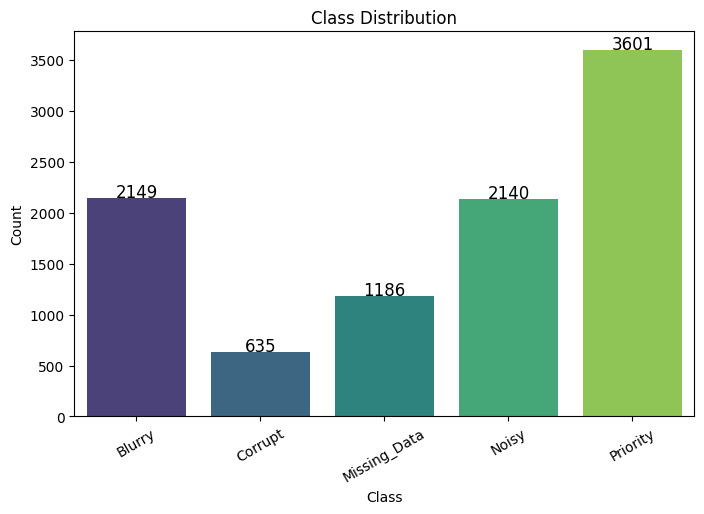

In [28]:
def plot_class_distribution(dataset, class_names):
    num_classes = len(class_names)
    class_counts = np.zeros(num_classes)

    # Unbatch the dataset to count each class
    for _, one_hot_label in dataset.unbatch():
        label = tf.argmax(one_hot_label).numpy()
        class_counts[label] += 1

    # Create a Seaborn barplot
    plt.figure(figsize=(8, 5))
    sns.barplot(x=class_names, y=class_counts, palette="viridis")

    # Add labels and title
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title("Class Distribution")
    plt.xticks(rotation=30)  # Rotate class names for better readability

    # Show values on top of bars
    for i, count in enumerate(class_counts):
        plt.text(i, count + 2, int(count), ha='center', fontsize=12)

    plt.show()

# Define class names
class_names = ["Blurry", "Corrupt", "Missing_Data", "Noisy", "Priority"]

# Plot class distribution 
plot_class_distribution(train_dataset, class_names)

---
#### Class Distribution  

The bar chart shows the frequency of images in the training dataset. `Priority` is the most common class, followed by `Blurry` and `Noisy,` while `Missing Data` and `Corrupt` are less frequent. This indicates a class imbalance.  

#### Note  

If the model struggles to classify certain categories effectively, we will revisit this imbalance and make necessary adjustments.  

### 3. Analyze Pixel Intensity Distributions per Channel

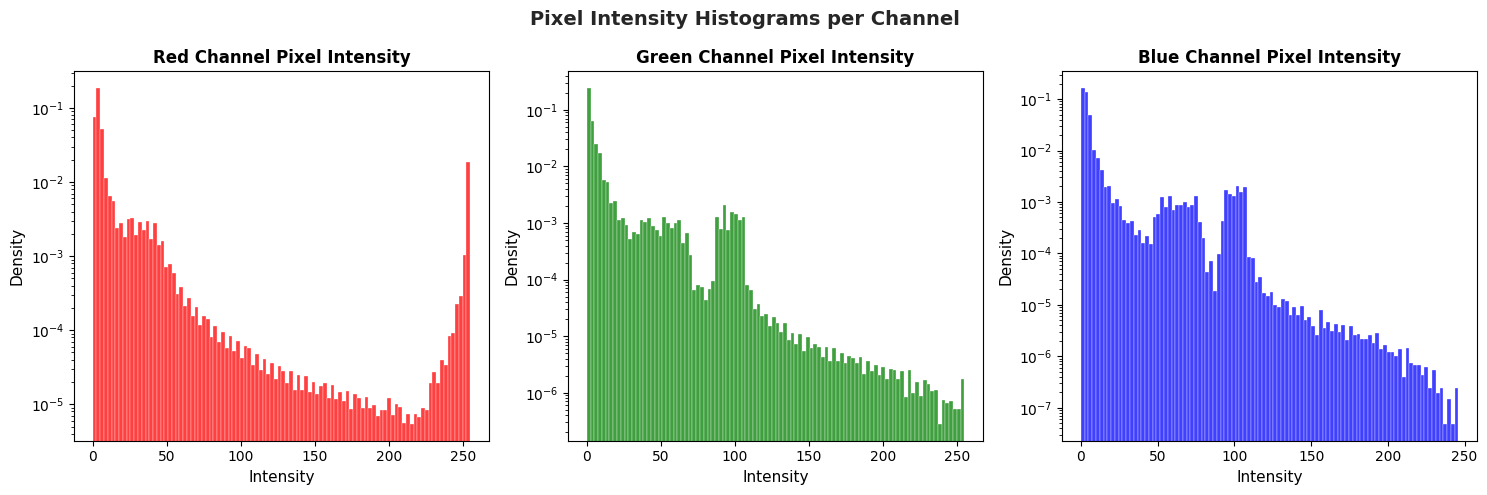

In [31]:
def plot_pixel_histograms(dataset, mean, var, num_batches=1, bins=100, log_scale=False):
    """
    Plots histograms of pixel intensities for each RGB channel
    from a given number of batches in the dataset.

    Parameters:
    - dataset: A tf.data.Dataset that yields (standardized_images, labels).
    - mean: tf.Tensor or NumPy array with shape (3,) containing the global mean.
    - var: tf.Tensor or NumPy array with shape (3,) containing the global variance.
    - num_batches: Number of batches to visualize (default: 1).
    - bins: Number of bins for the histogram (default: 100 for finer granularity).
    - log_scale: Whether to apply log-scaling to the y-axis (default: False).
    """
    for standardized_images, _ in dataset.take(num_batches):
        images = unnormalize(standardized_images, mean, var)
        images_np = np.clip(images.numpy(), 0, 255).astype(np.uint8)

        assert images_np.shape[-1] == 3, "Expected 3 channels (RGB), but got different shape."

        channel_names = ["Red", "Green", "Blue"]
        channel_colors = ["red", "green", "blue"]

        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        sns.set_style("whitegrid")

        for c in range(3):
            channel_data = images_np[..., c].ravel()
            sns.histplot(channel_data, bins=bins, ax=axs[c], color=channel_colors[c], stat="density")
            axs[c].set_title(f"{channel_names[c]} Channel Pixel Intensity", fontsize=12, fontweight="bold")
            axs[c].set_xlabel("Intensity", fontsize=11)
            axs[c].set_ylabel("Density", fontsize=11)

            if log_scale:
                axs[c].set_yscale("log")

        plt.suptitle("Pixel Intensity Histograms per Channel", fontsize=14, fontweight="bold")
        plt.tight_layout()
        plt.show()
 
# Plot pixel intensity histograms from one batch of the training dataset
plot_pixel_histograms(train_dataset, global_mean, global_var, num_batches=1, bins=100, log_scale=True)

In [ ]:
# Check disk usage in the working directory
!du -sh /kaggle/working/*

---
## Model Training with Pruning
---

In [26]:
# Define the main function to train the model
def main(epochs=40, batch_size=32, total_train_images=9711):
    # Print information about the dataset
    for images, _ in train_dataset.take(1):
        input_shape = images.shape[1:]  # Excluding batch dimension
        break
    print('Input shape:', input_shape)
    print(f"{tf.data.experimental.cardinality(train_dataset)} training batches available.")

    # Set up pruning parameters and build the model
    
    # Calculate pruning steps
    total_images = total_train_images
    batch_size = batch_size
    steps_per_epoch = total_images // batch_size  # Number of batches per epoch
    total_steps = steps_per_epoch * epochs  # epochs of training
    
    begin_step = int(0.1 * total_steps)  # Start pruning at 10% of training
    end_step = int(0.6 * total_steps)  # End pruning at 60% of training
    frequency = total_steps // epochs  # We have to adjust frequency based on training duration
    
    pruning_params = {
        'pruning_schedule': PolynomialDecay(
            initial_sparsity=0.1,
            final_sparsity=0.75,
            begin_step=begin_step,
            end_step=end_step,
            frequency=frequency)
    }

    # Build the model using pruning parameters
    layerwise_model = build_layerwise_model(input_shape, **pruning_params)
    models = [layerwise_model]

    # Train and save the model(s)
    train_and_save(models, 
                   train_dataset, val_dataset, test_dataset)

# Run the main function only if the script is executed directly
if __name__ == "__main__":
    main(epochs=40, batch_size=32, total_train_images=9711)

Input shape: (512, 512, 3)
-2 training batches available.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_separa  (None, 512, 512, 32)      253       
 ble_conv2d_6 (PruneLowMagn                                      
 itude)                                                          
                                                                 
 batch_normalization_6 (Bat  (None, 512, 512, 32)      128       
 chNormalization)                                                
                                                                 
 activation_8 (Activation)   (None, 512, 512, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 256, 256, 32)      0         
 g2D)                                                            
                                                              

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


304/304 [==============================] - ETA: 0s - loss: 0.2524 - accuracy: 0.9566
Epoch 2: val_loss improved from 2.64795 to 0.41292, saving model to /kaggle/working/best_checkpoint_model.h5
304/304 [==============================] - 65s 214ms/step - loss: 0.2524 - accuracy: 0.9566 - val_loss: 0.4129 - val_accuracy: 0.8338
Epoch 3/40
304/304 [==============================] - ETA: 0s - loss: 0.1770 - accuracy: 0.9722
Epoch 3: val_loss did not improve from 0.41292
304/304 [==============================] - 65s 213ms/step - loss: 0.1770 - accuracy: 0.9722 - val_loss: 0.6022 - val_accuracy: 0.7597
Epoch 4/40
304/304 [==============================] - ETA: 0s - loss: 0.1338 - accuracy: 0.9824
Epoch 4: val_loss improved from 0.41292 to 0.14119, saving model to /kaggle/working/best_checkpoint_model.h5
304/304 [==============================] - 65s 213ms/step - loss: 0.1338 - accuracy: 0.9824 - val_loss: 0.1412 - val_accuracy: 0.9827
Epoch 5/40
304/304 [==============================] - ET

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Test loss after loading SavedModel: 0.015089609660208225
Test accuracy after loading SavedModel: 1.0
Loading model from HDF5 format...
Test loss after loading HDF5 model: 0.015089609660208225
Test accuracy after loading HDF5 model: 1.0
Loading model from Pickle format...
Test loss after loading Pickle model: 0.015089609660208225
Test accuracy after loading Pickle model: 1.0
Converting the best model to TFLite format...
TFLite model saved at: /kaggle/working/model.tflite
Loading and evaluating the TFLite model...
TFLite Model Evaluation:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[ 668    0    0    0    0]
 [   0  213    0    0    0]
 [   0    0  414    0    0]
 [   0    0    0  721    0]
 [   0    0    0    0 1221]]


## Quantizing and Evaluating Pruned Model

In [50]:
# Compile_and_fit function with NaN stabilization.
def compile_and_fit(model, train_dataset, val_dataset, batch_size, epochs, train_dataset_size=9711, compile_kwargs={}, fit_kwargs={}):
    """
    Compiles and trains a Keras model with built-in stabilization to prevent NaN values during training.

    This function configures the model with a cosine decay restart learning rate schedule using a reduced initial learning rate 
    to improve numerical stability. It also applies gradient clipping via both `clipvalue` and `clipnorm` to control the magnitude 
    of gradient updates. In addition, a custom callback is used to monitor the training process for any occurrence of NaN values in 
    the loss or metric outputs; if detected, training is halted immediately.

    Parameters
    ----------
    model : keras.Model
        The Keras model to compile and train.
    train_dataset : tf.data.Dataset
        The TensorFlow Dataset to be used for training.
    val_dataset : tf.data.Dataset
        The TensorFlow Dataset to be used for validation.
    batch_size : int
        The number of samples per training batch.
    epochs : int
        The total number of training epochs.
    train_dataset_size : int, optional
        The total number of training samples (default is 9711). This is used to calculate the number of steps per epoch.
    compile_kwargs : dict, optional
        Additional keyword arguments to pass to the model's `compile` method.
    fit_kwargs : dict, optional
        Additional keyword arguments to pass to the model's `fit` method.

    Returns
    -------
    keras.Model
        The trained Keras model.

    Notes
    -----
    - The learning rate schedule is defined using `CosineDecayRestarts` with a lower initial learning rate (1e-4) for stability.
    - Both `clipvalue` and `clipnorm` are applied in the Adam optimizer to help mitigate the risk of exploding gradients.
    - The custom `NanDetectionCallback` is added to monitor for NaN values in the training logs; if any NaNs are detected in any batch, 
      training is immediately halted.
    """
    # Calculate the steps per epoch.
    steps_per_epoch = train_dataset_size // batch_size
    first_decay_steps = steps_per_epoch * epochs

    # Lower the initial learning rate for stability.
    lr_schedule = keras.optimizers.schedules.CosineDecayRestarts(
        initial_learning_rate=1e-4,  # Lowered from 1e-3.
        first_decay_steps=first_decay_steps,
        t_mul=2.0,
        m_mul=0.9,
        alpha=1e-5
    )

    # Use both clipvalue and clipnorm to control gradient updates.
    optimizer = keras.optimizers.Adam(
        learning_rate=lr_schedule,
        clipvalue=1.0,
        clipnorm=1.0
    )

    compile_args = {
        'optimizer': optimizer,
        'loss': keras.losses.categorical_crossentropy,
        'metrics': ['accuracy'],
    }
    compile_args.update(compile_kwargs)
    model.compile(**compile_args)

    # Custom callback to monitor for NaNs in training.
    class NanDetectionCallback(keras.callbacks.Callback):
        def on_batch_end(self, batch, logs=None):
            if logs:
                for key, value in logs.items():
                    if np.any(np.isnan(value)):
                        print(f"NaN detected in {key} at batch {batch}, stopping training.")
                        self.model.stop_training = True

    # Combine any existing callbacks with our NaN detection callback.
    callbacks = fit_kwargs.get('callbacks', [])
    callbacks.append(NanDetectionCallback())
    fit_kwargs['callbacks'] = callbacks

    # Prepare fit arguments.
    fit_args = {
        'validation_data': val_dataset,
        'batch_size': batch_size,
        'epochs': epochs
    }
    fit_args.update(fit_kwargs)

    model.fit(train_dataset, **fit_args)
    
    return model 

In [51]:
def prune_preserve_quantize_model(saved_model_path, train_dataset, val_dataset, 
                                  test_dataset, batch_size, epochs, train_dataset_size):
    """
    Loads a pruned model, applies quantization, fine-tunes it with training data, and exports
    the resulting quantization-aware model in various formats (SavedModel, HDF5, Pickle, TFLite).
    
    The function follows these steps:
    
    1. **Load and Strip Pruning:**
       - Loads a pruned model from the provided `saved_model_path` within a custom quantization scope
         (which registers the custom pruning wrapper).
       - Removes the pruning wrappers using `prune.strip_pruning()`.
       
    2. **Quantization Annotation and Application:**
       - Annotates the pruned model for quantization using `quantize.quantize_annotate_model()`.
       - Applies quantization (using a default 8-bit prune-preserve quantization scheme) via 
         `quantize.quantize_apply()`.
       - Prints the model summary of the resulting quantization-aware model.
       
    3. **Quantization-Aware Fine-Tuning:**
       - Compiles and fine-tunes the quantization-aware model on the provided `train_dataset` and `val_dataset`.
       - Uses callbacks including:
         - Early stopping (monitors validation loss with a patience of 5 epochs and restores the best weights).
         - Model checkpointing (saves the best model based on validation loss).
       - The training is performed using the helper function `compile_and_fit()`, which should be defined 
         elsewhere in your code.
       
    4. **Model Evaluation and Export:**
       - Loads the best model saved during fine-tuning (within a quantization scope) and evaluates it on 
         `test_dataset`.
       - Saves the best model in three formats:
         - TensorFlow SavedModel format.
         - HDF5 format.
         - Pickle format (saves the model architecture as JSON and its weights).
       - Optionally verifies the SavedModel and HDF5 formats by reloading and evaluating them on the test set.
       
    5. **TFLite Conversion and Evaluation:**
       - Converts the best model to TFLite format with default optimizations.
       - Saves the TFLite model to disk.
       - Loads and evaluates the TFLite model on the test dataset:
         - For each sample, inference is performed using the TFLite interpreter.
         - Computes evaluation metrics such as accuracy, precision, recall, F1 score, and the confusion matrix.
         
    6. **Return:**
       - Returns the best quantization-aware model after fine-tuning.
    
    Parameters:
    -----------
    saved_model_path : str
        File path to the saved pruned model (with pruning wrappers) in TensorFlow format.
    train_dataset : tf.data.Dataset
        The training dataset used for fine-tuning the quantization-aware model.
    val_dataset : tf.data.Dataset
        The validation dataset for monitoring training progress and early stopping.
    test_dataset : tf.data.Dataset
        The test dataset used for final evaluation of the quantized model.
    batch_size : int
        Batch size for training and evaluation.
    epochs : int
        Number of training epochs for fine-tuning.
    train_dataset_size : int
        The total number of samples in the training dataset (used by the training function).
    
    Returns:
    --------
    best_model : tf.keras.Model
        The best quantization-aware model obtained after fine-tuning, evaluated on the test dataset.
    """
    
    # Load the pruned model (wrapped with custom pruning scope)
    with quantize_scope({'PruneLowMagnitude': prune.pruning_wrapper.PruneLowMagnitude}):
        pruned_model = keras.models.load_model(saved_model_path)
    
    # Remove pruning wrappers before quantization.
    pruned_model = prune.strip_pruning(pruned_model)
    
    # Annotate and apply quantization.
    quant_aware_annotate_model = quantize.quantize_annotate_model(pruned_model)
    quant_aware_model = quantize.quantize_apply(
        quant_aware_annotate_model,
        scheme=default_8bit_prune_preserve_quantize_scheme.Default8BitPrunePreserveQuantizeScheme()
    )
    
    quant_aware_model.summary()

    # Define callbacks for training, including early stopping.
    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=5, mode='auto', 
                                      restore_best_weights=True),
        keras.callbacks.ModelCheckpoint('/kaggle/working/quantized/best_checkpoint_model.h5', 
                                        monitor='val_loss', save_best_only=True, 
                                        mode='auto', verbose=1)
    ]
    
    fit_kwargs = {
        'batch_size': batch_size,
        'epochs': epochs,
        'callbacks': callbacks
    }
    
    compile_and_fit(
        quant_aware_model,
        train_dataset,
        val_dataset,
        batch_size, 
        epochs,
        train_dataset_size,
        compile_kwargs={},  # Additional compile settings if needed.
        fit_kwargs=fit_kwargs
    )

    # Load the best model saved during training.
    with quantize_scope({'QuantizeWrapper': quantize.quantize_wrapper.QuantizeWrapper}):
        best_model = keras.models.load_model('/kaggle/working/quantized/best_checkpoint_model.h5')
    
    # Evaluate on test data.
    score = best_model.evaluate(test_dataset, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    # Save the best model in various formats.
    saved_model_dir = '/kaggle/working/quantized/saved_model/'
    print('Saving model to TensorFlow SavedModel format at:', saved_model_dir)
    keras.models.save_model(best_model, saved_model_dir, save_format='tf')

    h5_file = '/kaggle/working/quantized/best_model.h5'
    print('Saving model to HDF5 format at:', h5_file)
    best_model.save(h5_file, save_format='h5')

    pkl_file = '/kaggle/working/quantized/model.pkl'
    print('Saving model to Pickle format at:', pkl_file)
    model_json = best_model.to_json()
    model_weights = best_model.get_weights()
    with open(pkl_file, 'wb') as f:
        pickle.dump({'model_json': model_json, 'model_weights': model_weights}, f)

    # Optionally verify SavedModel and HDF5 formats by reloading and evaluating.
    print('Loading model from TensorFlow SavedModel format...')
    loaded_model = keras.models.load_model(saved_model_dir)
    score = loaded_model.evaluate(test_dataset, verbose=0)
    print('Test loss after loading SavedModel:', score[0])
    print('Test accuracy after loading SavedModel:', score[1])
    
    print('Loading model from HDF5 format...')
    with quantize_scope({'QuantizeWrapper': quantize.quantize_wrapper.QuantizeWrapper}):
        loaded_h5_model = keras.models.load_model(h5_file)
    score = loaded_h5_model.evaluate(test_dataset, verbose=0)
    print('Test loss after loading HDF5 model:', score[0])
    print('Test accuracy after loading HDF5 model:', score[1])
    
    # Convert and save as TFLite.
    print('Converting the best model to TFLite format...')
    converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()
    tflite_file = '/kaggle/working/quantized/model.tflite'
    with open(tflite_file, 'wb') as f:
        f.write(tflite_model)
    print('TFLite model saved at:', tflite_file)

    # Evaluate the TFLite model.
    print('Loading and evaluating the TFLite model...')
    interpreter = tf.lite.Interpreter(model_path=tflite_file)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    predictions = []
    ground_truth = []
    
    for batch_images, batch_labels in test_dataset:
        batch_images_np = batch_images.numpy()
        batch_labels_np = batch_labels.numpy()
        for i in range(len(batch_images_np)):
            # Process ground truth label.
            label = batch_labels_np[i]
            if label.ndim > 0:
                label = np.argmax(label)
            ground_truth.append(label)
            
            # Run inference on the TFLite model.
            input_data = np.expand_dims(batch_images_np[i], axis=0)
            interpreter.set_tensor(input_details[0]['index'], input_data)
            interpreter.invoke()
            output_data = interpreter.get_tensor(output_details[0]['index'])
            predictions.append(np.argmax(output_data))
    
    # Compute evaluation metrics.
    tflite_accuracy = accuracy_score(ground_truth, predictions)
    tflite_precision = precision_score(ground_truth, predictions, average='weighted')
    tflite_recall = recall_score(ground_truth, predictions, average='weighted')
    tflite_f1 = f1_score(ground_truth, predictions, average='weighted')
    tflite_cm = confusion_matrix(ground_truth, predictions)
    
    print('TFLite Model Evaluation:')
    print('Accuracy:', tflite_accuracy)
    print('Precision:', tflite_precision)
    print('Recall:', tflite_recall)
    print('F1 Score:', tflite_f1)
    print('Confusion Matrix:\n', tflite_cm)
    
    return best_model

In [53]:
# First model saved path
first_model_saved_path = '/kaggle/working/saved_model/'  # Pointing to the correct model file

# Apply quantization to the first model
print(f"Applying quantization to the first model: ")
quantized_model = prune_preserve_quantize_model(first_model_saved_path, train_dataset, val_dataset,
                                               test_dataset, batch_size=32, epochs=4,
                                               train_dataset_size=9711)

Applying quantization to the first model: 
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_6 (Quantize  (None, 512, 512, 3)       3         
 Layer)                                                          
                                                                 
 quant_depthwise_conv2d_18   (None, 512, 512, 3)       32        
 (QuantizeWrapperV2)                                             
                                                                 
 quant_conv2d_18 (QuantizeW  (None, 512, 512, 32)      193       
 rapperV2)                                                       
                                                                 
 quant_batch_normalization_  (None, 512, 512, 32)      129       
 6 (QuantizeWrapperV2)                                           
                                                                 
 quant_acti

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


304/304 [==============================] - ETA: 0s - loss: 0.0271 - accuracy: 0.9966
Epoch 2: val_loss improved from 0.01767 to 0.01487, saving model to /kaggle/working/quantized/best_checkpoint_model.h5
304/304 [==============================] - 91s 299ms/step - loss: 0.0271 - accuracy: 0.9966 - val_loss: 0.0149 - val_accuracy: 1.0000
Epoch 3/4
304/304 [==============================] - ETA: 0s - loss: 0.0237 - accuracy: 0.9981
Epoch 3: val_loss did not improve from 0.01487
304/304 [==============================] - 91s 299ms/step - loss: 0.0237 - accuracy: 0.9981 - val_loss: 0.0151 - val_accuracy: 1.0000
Epoch 4/4
304/304 [==============================] - ETA: 0s - loss: 0.0231 - accuracy: 0.9981
Epoch 4: val_loss did not improve from 0.01487
304/304 [==============================] - 91s 298ms/step - loss: 0.0231 - accuracy: 0.9981 - val_loss: 0.0151 - val_accuracy: 1.0000
Test loss: 0.014860168099403381
Test accuracy: 1.0
Saving model to TensorFlow SavedModel format at: /kaggle/wo

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Test loss after loading SavedModel: 0.014860160648822784
Test accuracy after loading SavedModel: 1.0
Loading model from HDF5 format...
Test loss after loading HDF5 model: 0.014860168099403381
Test accuracy after loading HDF5 model: 1.0
Converting the best model to TFLite format...


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


TFLite model saved at: /kaggle/working/quantized/model.tflite
Loading and evaluating the TFLite model...
TFLite Model Evaluation:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[ 668    0    0    0    0]
 [   0  213    0    0    0]
 [   0    0  414    0    0]
 [   0    0    0  721    0]
 [   0    0    0    0 1221]]


---

### Evaluation Process

The evaluation will run on a single CPU core and will assess the entire machine learning pipeline, including data preprocessing, model performance, and resource efficiency. The pipeline is tested using the disk-based preprocessing method with the test dataset containing both images and labels.

#### Metrics Evaluated:
1. **Accuracy & Model Performance**:
   - **Accuracy**: Correct predictions.
   - **F1 Score**: Balanced precision and recall for imbalanced datasets.
   - **Confusion Matrix**: Breakdown of predictions by classes (Priority, Noisy, Blurry, Corrupt, Missing_Data).

2. **Evaluation Time**:
   - The pipeline runs on a single CPU core to simulate a resource-constrained environment.
   - Faster pipelines are crucial for scalability and practical use.

3. **Memory Usage**:
   - **Peak Memory Usage**: Maximum memory during execution.
   - **Average CPU Usage**: CPU usage on a single core.

4. **Algorithm Code Size**:
   - Size of the pipeline, including serialized model and preprocessing function, measured in megabytes (MB).

#### Test Setup:
- The disk-based pipeline will process the test dataset that includes both images and labels.
- Evaluation will ensure the pipeline meets performance and efficiency requirements.

--- 

In [54]:
# Function to monitor memory and CPU usage
def monitor_resources(mem_usage, cpu_usage, stop_event):
    process = psutil.Process(os.getpid())
    while not stop_event.is_set():
        mem = process.memory_info().rss / (1024 * 1024)  # Memory in MB
        cpu = process.cpu_percent(interval=None)  # CPU usage percentage
        mem_usage.append(mem)
        cpu_usage.append(cpu)
        time.sleep(0.1)  # Sampling interval

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, class_names):
    """
    Plot a confusion matrix with labels.

    Parameters:
    - cm: Confusion matrix.
    - class_names: List of class names.
    """
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Function to print evaluation results
def print_evaluation_results(metrics, class_names):
    """
    Print evaluation metrics and display the confusion matrix.

    Parameters:
    - metrics: Dictionary containing evaluation metrics.
    - class_names: List of class names for the confusion matrix.
    """
    print("\n### Evaluation Metrics ###\n")
    print(f"Evaluation Time:       {metrics['inference_time']:.2f} seconds")
    print(f"Peak Memory Usage:     {metrics['peak_memory_usage']:.2f} MB")
    print(f"Average CPU Usage:     {metrics['average_cpu_usage']:.2f} %")
    print(f"Model Size:            {metrics['model_size_mb']:.2f} MB")
    print(f"Accuracy:              {metrics['accuracy']:.3f}")
    print(f"F1 Score:              {metrics['f1']:.3f}")

    # Plot confusion matrix
    print("\n### Confusion Matrix ###\n")
    plot_confusion_matrix(metrics['confusion_matrix'], class_names)

# Function to compute evaluation metrics
def compute_metrics(y_test, y_pred):
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_test, y_pred)
    metrics['precision'] = precision_score(y_test, y_pred, average='weighted')
    metrics['recall'] = recall_score(y_test, y_pred, average='weighted')
    metrics['f1'] = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    metrics['confusion_matrix'] = cm
    return metrics

# Function to calculate model size
def calculate_model_size(model_path):
    model_size_kb = os.path.getsize(model_path) / 1024  # Size in KB
    model_size_mb = model_size_kb / 1024  # Size in MB
    return model_size_mb

def evaluate_quantized_model(tflite_model_path, test_dataset):
    """
    Evaluates a quantized TFLite model using a preprocessed tf.data.Dataset.
    
    Parameters:
    - tflite_model_path: Path to the TFLite model file.
    - test_dataset: A tf.data.Dataset yielding (image, label) pairs.
      Note: The labels can be one-hot encoded; this function will convert them to integers.
      
    Returns:
    - metrics: Dictionary containing evaluation metrics.
    """
    # Set CPU affinity (optional)
    p = psutil.Process(os.getpid())
    p.cpu_affinity([3])
    
    # Resource monitoring lists
    mem_usage = []
    cpu_usage = []

    # Start memory tracking
    tracemalloc.start()
    
    # Event to stop monitoring
    stop_monitoring = threading.Event()
    
    # Start monitoring in a separate thread
    monitor_thread = threading.Thread(target=monitor_resources, args=(mem_usage, cpu_usage, stop_monitoring))
    monitor_thread.start()

    # Start timing
    start_time = time.time()

    # Load and initialize the TFLite interpreter
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    predictions = []
    ground_truth = []

    # Iterate over the test dataset (which is preprocessed, batched, and prefetched)
    for batch_images, batch_labels in test_dataset:
        # Convert tensors to NumPy arrays
        batch_images = batch_images.numpy()
        batch_labels = batch_labels.numpy()
        
        for i in range(batch_images.shape[0]):
            image = batch_images[i]
            # Convert one-hot label to integer label (if necessary)
            if batch_labels[i].ndim > 0:
                true_label = np.argmax(batch_labels[i])
            else:
                true_label = batch_labels[i]
            ground_truth.append(true_label)

            # Prepare input data by adding a batch dimension
            input_data = np.expand_dims(image, axis=0)
            interpreter.set_tensor(input_details[0]['index'], input_data)
            interpreter.invoke()
            output_data = interpreter.get_tensor(output_details[0]['index'])
            pred = np.argmax(output_data)
            predictions.append(pred)

    # Stop timing
    inference_time = time.time() - start_time

    # Stop resource monitoring
    stop_monitoring.set()
    monitor_thread.join()

    # Get peak memory usage (in MB)
    _, peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    peak_memory = peak_memory / (1024 * 1024)

    # Compute evaluation metrics using true labels and predictions
    metrics = compute_metrics(ground_truth, predictions)

    # Get model size in MB
    model_size_mb = calculate_model_size(tflite_model_path)

    # Compute CPU usage statistics
    peak_cpu_usage = max(cpu_usage) if cpu_usage else 0
    avg_cpu_usage = np.mean(cpu_usage) if cpu_usage else 0

    # Add all metrics to the dictionary
    metrics.update({
        'inference_time': inference_time,
        'model_size_mb': model_size_mb,
        'peak_cpu_usage': peak_cpu_usage,
        'average_cpu_usage': avg_cpu_usage,
        'peak_memory_usage': peak_memory,
    })

    print_evaluation_results(metrics, 
                             class_names=["Blurry", "Corrupt", "Missing_Data", "Noisy", "Priority"])

    # Clean up
    del predictions, interpreter, mem_usage, cpu_usage, stop_monitoring, monitor_thread
    gc.collect()
    return metrics


### Evaluation Metrics ###

Evaluation Time:       141.95 seconds
Peak Memory Usage:     198.36 MB
Average CPU Usage:     74.36 %
Model Size:            0.03 MB
Accuracy:              1.000
F1 Score:              1.000

### Confusion Matrix ###



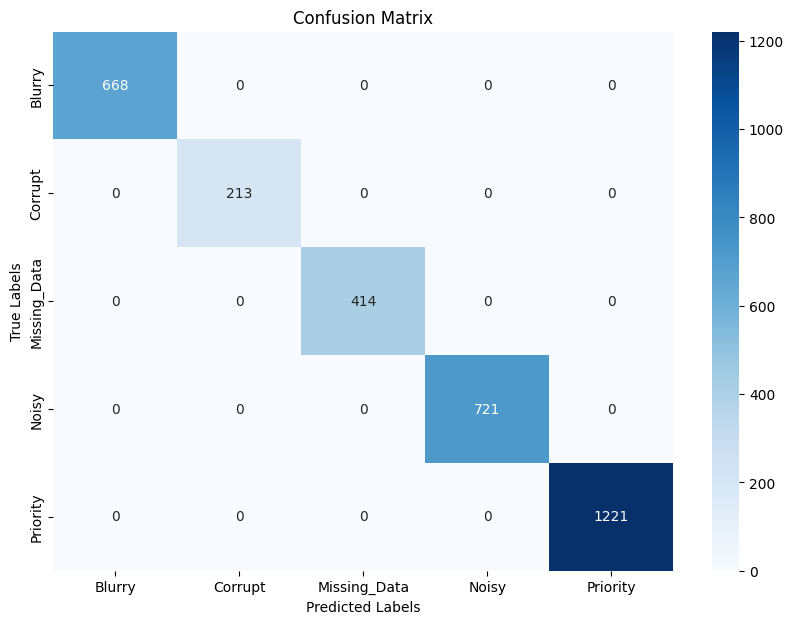

In [55]:
# Quantized model path
tflite_model_path = "/kaggle/working/quantized/model.tflite"

# Evluate the model based on the specified metrics
metrics = evaluate_quantized_model(tflite_model_path, test_dataset)

---
### Save all directories and files
---

In [2]:
# Path to the working directory
working_dir = '/kaggle/working'

# Path to exclude
exclude_dir = os.path.join(working_dir, '10hack')

# Get a list of all files and directories in working_dir
files_and_dirs = os.listdir(working_dir)

# Filter out the '10hack' folder
files_to_download = [f for f in files_and_dirs if os.path.join(working_dir, f) != exclude_dir]

# Create a temporary directory to store the files to be zipped
temp_dir = '/kaggle/working/temp_files'
os.makedirs(temp_dir, exist_ok=True)

# Move the files to the temporary directory
for file in files_to_download:
    shutil.move(os.path.join(working_dir, file), os.path.join(temp_dir, file))

# Zip the temporary directory
shutil.make_archive('/kaggle/working/working_files', 'zip', temp_dir)

# Clean up: Remove the temporary directory and its contents
shutil.rmtree(temp_dir)

# The zip file '/kaggle/working/working_files.zip' is now ready for download